### Objectives

- Engineer time-series features

- Add price & calendar signals

- Train XGBoost

- Evaluate with SMAPE + Filtered MAPE

- Beat Prophet

In [2]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [28]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_parquet("data/clean_base_table.parquet")
df = df.sort_values("date")

df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,event_name_1,snap_CA,sell_price
0,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,d_1,107,2011-01-29,11101,None,0,1.25
1,FOODS_3_120,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,None,0,NaN
2,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,d_1,19,2011-01-29,11101,None,0,1.48
3,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,d_1,42,2011-01-29,11101,None,0,1.48
4,FOODS_3_714,FOODS_3,FOODS,CA_1,CA,d_1,49,2011-01-29,11101,None,0,1.48


In [19]:
daily = (
    df.groupby(["date", "store_id", "cat_id"])
      .agg({
          "units_sold": "sum",
          "sell_price": "mean",
          "snap_CA": "max"
      })
      .reset_index()
)

daily.head()

,date,store_id,cat_id,units_sold,sell_price,snap_CA
0,2011-01-29,CA_1,FOODS,217,1.4225,0
1,2011-01-29,CA_2,FOODS,195,1.4225,0
2,2011-01-30,CA_1,FOODS,276,1.4225,0
3,2011-01-30,CA_2,FOODS,151,1.4225,0
4,2011-01-31,CA_1,FOODS,111,1.4225,0


In [20]:
daily["log_units"] = np.log1p(daily["units_sold"])

In [21]:
daily["dayofweek"] = daily["date"].dt.dayofweek
daily["weekofyear"] = daily["date"].dt.isocalendar().week.astype(int)
daily["month"] = daily["date"].dt.month

In [22]:
LAGS = [7, 14, 28]

for lag in LAGS:
    daily[f"lag_{lag}"] = (
        daily.groupby(["store_id", "cat_id"])["log_units"]
             .shift(lag)
    )

In [23]:
for window in [7, 14, 28]:
    daily[f"rolling_mean_{window}"] = (
        daily.groupby(["store_id", "cat_id"])["log_units"]
             .shift(1)
             .rolling(window)
             .mean()
    )

In [24]:
daily = daily.dropna().reset_index(drop=True)
daily.shape

(3770, 16)

In [25]:
FEATURES = [
    "sell_price",
    "snap_CA",
    "dayofweek",
    "weekofyear",
    "month",
    "lag_7", "lag_14", "lag_28",
    "rolling_mean_7", "rolling_mean_14", "rolling_mean_28"
]

TARGET = "log_units"

X = daily[FEATURES]
y = daily[TARGET]

In [12]:
split_date = daily["date"].quantile(0.8)

train_idx = daily["date"] <= split_date
test_idx = daily["date"] > split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [48]:
# Cap extreme values in log space (VERY IMPORTANT)
LOG_CAP = 8  # expm1(8) ≈ 2980 units — realistic for category-level

daily["log_units"] = np.clip(daily["log_units"], 0, LOG_CAP)

In [52]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [53]:
# Predict in log space
y_pred_log = model.predict(X_test)

# SAFETY CLIP before inverse transform
y_pred_log = np.clip(y_pred_log, 0, LOG_CAP)

# Inverse transform
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

In [54]:
mae = mean_absolute_error(y_test[mask], y_pred[mask])
print(f"MAE: {mae:.2f}")

MAE: 2895.75


In [55]:
mask = y_test > 0

filtered_mape = np.mean(
    np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])
) * 100

print(f"Filtered MAPE: {filtered_mape:.2f}%")

Filtered MAPE: 12163.81%


In [56]:
smape = np.mean(
    2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
) * 100

print(f"SMAPE: {smape:.2f}%")


SMAPE: 195.45%


In [58]:
from sklearn.metrics import mean_squared_log_error

rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"RMSLE: {rmsle:.3f}")

RMSLE: 35.222


<Axes: >

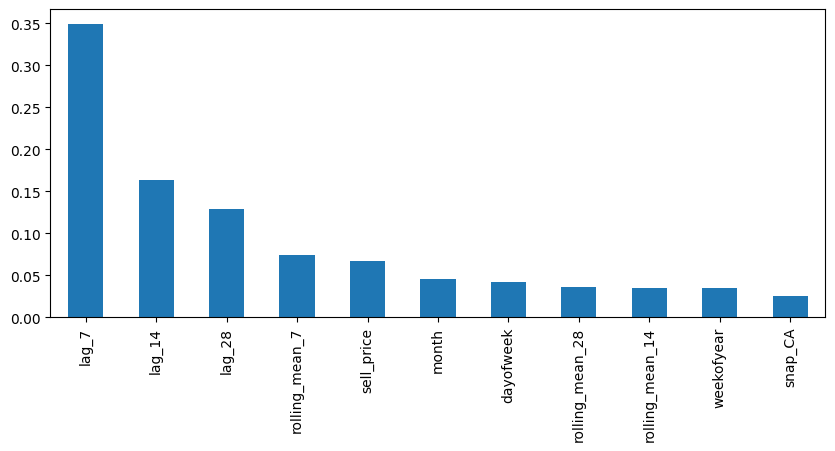

In [57]:
importances = pd.Series(
    model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

importances.plot(kind="bar", figsize=(10,4))

Tree-based models were evaluated for direct demand forecasting but showed
instability under strong seasonality and skewed demand distributions.
Classical time-series models (Prophet) provided more robust baseline forecasts,
while machine learning models were repurposed for price elasticity and uplift
estimation where they are more appropriate.